In [40]:
import pandas as pd
import numpy as np
from pathlib import Path
import os.path
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
train_img_dir = Path('PandasBears/Train')
test_img_dir = Path('PandasBears/Test')

# Creating Train_df

In [8]:
filepath = list(train_img_dir.glob(r'**/*.jpeg'))
Label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepath))
filepath = pd.Series(filepath, name = "Filepath").astype(str)
Label = pd.Series(Label, name = 'Label')
train_df = pd.concat([filepath, Label], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)

# Creating Test_df

In [9]:
filepath = list(test_img_dir.glob(r'**/*.jpeg'))
Label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepath))
filepath = pd.Series(filepath, name = "Filepath").astype(str)
Label = pd.Series(Label, name = 'Label')
test_df = pd.concat([filepath, Label], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)

In [10]:
train_df.shape

(500, 2)

In [11]:
test_df.shape

(100, 2)

# Image Generator

In [12]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                           rotation_range = 30,
                                                           zoom_range = 0.2,
                                                           width_shift_range=0.1,
                                                           height_shift_range = 0.1,
                                                           horizontal_flip = True,
                                                           vertical_flip = False,
                                                           validation_split = 0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [13]:
train_img = train_gen.flow_from_dataframe(dataframe = train_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = 42,
                                         subset = 'training')
val_img = train_gen.flow_from_dataframe(dataframe = train_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = 42,
                                         subset = 'validation')
test_img = test_gen.flow_from_dataframe(dataframe = test_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = False)

Found 400 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


# Model Training

In [31]:
inputs = tf.keras.Input(shape = (224,224,3))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3),activation = 'relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
history = model.fit(train_img, validation_data = val_img,
                   epochs = 100,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                               patience = 5,
                                                               restore_best_weights = True))


2023-01-04 07:00:18.529843: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
13/13 [==============================] - 12s 849ms/step - loss: 0.6886 - accuracy: 0.4825 - val_loss: 0.6935 - val_accuracy: 0.4200
Epoch 2/100
13/13 [==============================] - 10s 752ms/step - loss: 0.6566 - accuracy: 0.5675 - val_loss: 0.6345 - val_accuracy: 0.9400
Epoch 3/100
13/13 [==============================] - 10s 742ms/step - loss: 0.5641 - accuracy: 0.8450 - val_loss: 0.5000 - val_accuracy: 0.8700
Epoch 4/100
13/13 [==============================] - 10s 740ms/step - loss: 0.3515 - accuracy: 0.9600 - val_loss: 0.2631 - val_accuracy: 0.9500
Epoch 5/100
13/13 [==============================] - 10s 734ms/step - loss: 0.1621 - accuracy: 0.9675 - val_loss: 0.1060 - val_accuracy: 0.9800
Epoch 6/100
13/13 [==============================] - 10s 746ms/step - loss: 0.0788 - accuracy: 0.9800 - val_loss: 0.0921 - val_accuracy: 0.9700
Epoch 7/100
13/13 [==============================] - 10s 744ms/step - loss: 0.0885 - accuracy: 0.9675 - val_loss: 0.1812 - val_accuracy:

# Results

In [37]:
results = model.evaluate(test_img, verbose = 0)
print(f'Test Loss : {round(results[0], 3)}')
print(f'Test Accuracy : {round(results[1], 4)*100}%')

Test Loss : 0.037
Test Accuracy : 99.0%


# Training & Validation Image (Accuracy vs Loss ) - Panda vs Bear

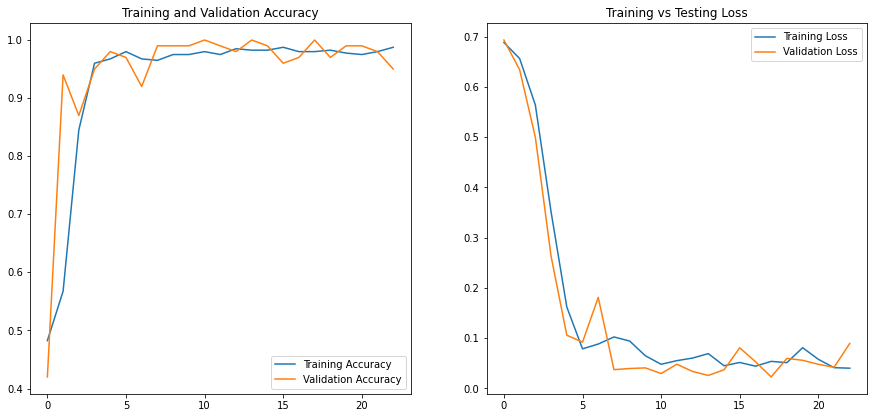

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(23)
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plt.plot(epochs_range, acc,label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training vs Testing Loss')
plt.show()

# Confusion Matrix & Classification Report for Pandas vs Bear Images

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


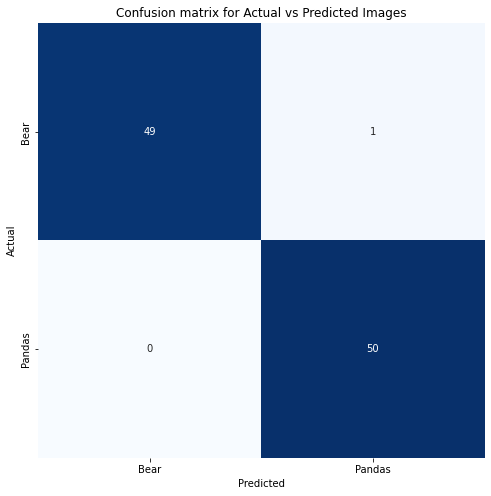

Classification Report---------->
               precision    recall  f1-score   support

        Bear       1.00      0.98      0.99        50
      Pandas       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [50]:
test_img_pred = (model.predict(test_img) >= 0.5).astype(np.int)
cm = confusion_matrix(test_img.labels, test_img_pred, labels =[0,1])
clr = classification_report(test_img.labels, test_img_pred, labels = [0,1], target_names= ['Bear','Pandas'])
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, fmt = 'g', cbar = False, cmap = 'Blues')
plt.title('Confusion matrix for Actual vs Predicted Images')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks = [0.5, 1.5], labels= ['Bear','Pandas'])
plt.yticks(ticks= [0.5, 1.5], labels= ['Bear','Pandas'])
plt.show()
print('Classification Report---------->\n',clr)
                            
                            